Speeding up the transformers

1. Mixed Precision.
2. Parameter Sharing.
3. One cycle policy.
4. d_ff 128 ( hidden layer of feed forward network).
5. Dynamic Padding



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/AI/ERA_course/session15/

In [2]:
! lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   43 bits physical, 48 bits virtual
CPU(s):                          32
On-line CPU(s) list:             0-31
Thread(s) per core:              2
Core(s) per socket:              16
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       AuthenticAMD
CPU family:                      23
Model:                           49
Model name:                      AMD EPYC 7282 16-Core Processor
Stepping:                        0
Frequency boost:                 enabled
CPU MHz:                         3199.259
CPU max MHz:                     2800.0000
CPU min MHz:                     1500.0000
BogoMIPS:                        5600.32
Virtualization:                  AMD-V
L1d cache:                       512 KiB
L1i cache:                       512 KiB
L2 cache:                        8

In [1]:
!pip install datasets --quiet
!pip install transformers --quiet
!pip install torchmetrics --quiet
!pip install tensorboard --quiet
!pip install lightning==2.0.1 --quiet
!pip install seaborn

import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger,CSVLogger
import torch
import torch.nn as nn
import torchmetrics
import warnings
warnings.filterwarnings("ignore")
import logging
from torch.optim.lr_scheduler import OneCycleLR
import seaborn as sn
import pandas as pd

In [2]:
from model import build_transformer
from config import get_config
from train import get_ds
from transformers import DataCollatorWithPadding


warnings.filterwarnings("ignore")

logger = logging.getLogger("Transformer")
logger.setLevel(level=logging.INFO)
fileHandler = logging.FileHandler(filename='prediction.log')
fileHandler.setLevel(level=logging.INFO)
logger.addHandler(fileHandler)

cfg = get_config()
cfg['preload'] = None
cfg['num_epochs'] = 30
cfg['batch_size'] = 16

In [3]:
#### Loading Datasets
train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(cfg)

In [5]:
class LitTr(pl.LightningModule):
    def __init__(self,cfg,tokenizer_src,tokenizer_tgt):
        super().__init__()

        vocab_src_len = tokenizer_src.get_vocab_size()
        vocab_tgt_len = tokenizer_tgt.get_vocab_size()
        self.model    = build_transformer(vocab_src_len, vocab_tgt_len, cfg['seq_len'], cfg['seq_len'], d_model=cfg['d_model'])
        self.loss_fn  = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1)
        self.BATCH_SIZE = cfg['batch_size']
        self.num_epochs = cfg['num_epochs']
        self.lr = cfg['lr']
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.seq_len = cfg['seq_len']
        self.expected = []
        self.predicted = []
        self.initial_epoch = 0
        self.save_hyperparameters()
        self.train_loss = []


    def forward(self, x):

        return self.model(x)

    def training_step(self, batch, batch_idx):

        encoder_input = batch['encoder_input']
        decoder_input = batch['decoder_input']
        encoder_mask  = batch['encoder_mask']
        decoder_mask  = batch['decoder_mask']

        # Run the tensors through the encoder, decoder and the projection layer
        encoder_output = self.model.encode(encoder_input, encoder_mask) # (b, seq_len, d_model)
        decoder_output = self.model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
        proj_output = self.model.project(decoder_output) # ( b, seq_len, vocab_size)

        label = batch['label']

        loss = self.loss_fn(proj_output.view(-1, self.tokenizer_tgt.get_vocab_size()), label.view(-1))
        self.train_loss.append(loss)

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True,logger=True)
        return loss

    def casual_mask(self, size):
        mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
        return(mask == 0)

    def greedy_decode(self,source, source_mask):

        sos_idx = self.tokenizer_tgt.token_to_id('[SOS]')
        eos_idx = self.tokenizer_tgt.token_to_id('[EOS]')

        encoder_output = self.model.encode(source, source_mask)
        decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source)

        while True:
            if decoder_input.size(1) == self.seq_len:
              break

            decoder_mask = self.casual_mask(decoder_input.size(1)).type_as(source_mask)

            out = self.model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

            prob = self.model.project(out[:,-1])
            _,next_word = torch.max(prob, dim=1)

            decoder_input = torch.cat(
                [decoder_input, torch.empty(1,1).type_as(source).fill_(next_word.item())], dim=1
            )

            if next_word == eos_idx:
              break

        return decoder_input.squeeze(0)

    def on_train_epoch_end(self):

        self.log('loss', torch.stack(self.train_loss).mean(), on_epoch=True, logger=True)
        print(f"Epoch {self.current_epoch} : Loss Mean - {torch.stack(self.train_loss).mean()}")
        self.train_loss.clear()

    def evaluate(self, batch, stage=None):

        encoder_input = batch["encoder_input"]
        encoder_mask  = batch["encoder_mask"]


        model_out = self.greedy_decode(encoder_input, encoder_mask)

        source_text = batch["src_text"][0]
        target_text = batch["tgt_text"][0]


        model_out_text = self.tokenizer_tgt.decode(model_out.detach().cpu().numpy())

        logger.info(f"SOURCE - {source_text}")
        logger.info(f"TARGET - {target_text}")
        logger.info(f"PREDICTED - {model_out_text}")
        logger.info("=============================================================")

        self.expected.append(target_text)
        self.predicted.append(model_out_text)


    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def on_validation_epoch_end(self):
        metric = torchmetrics.CharErrorRate()
        cer = metric(self.predicted, self.expected)
        self.log('validation_cer', cer, prog_bar=True, on_epoch=True, logger=True)


        # Compute the word error rate
        metric = torchmetrics.WordErrorRate()
        wer = metric(self.predicted, self.expected)
        self.log('validation_wer', wer, prog_bar=True, on_epoch=True, logger=True)

        # Compute the BLEU metric
        metric = torchmetrics.BLEUScore()
        bleu = metric(self.predicted, self.expected)
        self.log('validation_bleu', bleu, prog_bar=True, on_epoch=True, logger=True)

        self.expected.clear()
        self.predicted.clear()

    def optimizer_zero_grad(self, epoch, batch_idx, optimizer):
        optimizer.zero_grad(set_to_none=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.lr, eps = 1e-9)
        scheduler = OneCycleLR(
                        optimizer,
                        max_lr= 10**-3,
                        pct_start = 1/10,
                        epochs=self.trainer.max_epochs,
                        steps_per_epoch=len(train_dataloader),
                        div_factor=10,
                        three_phase=True,
                        final_div_factor=10,
                        anneal_strategy='linear'
                    )
        return {
             "optimizer": optimizer,
             "lr_scheduler": {"scheduler": scheduler, "interval": "step"},
             }

In [6]:
trainer = pl.Trainer(log_every_n_steps=1,
                     #accumulate_grad_batches=5,
                     limit_val_batches=2,
                     check_val_every_n_epoch=1,
                     max_epochs = cfg['num_epochs'],
                     accelerator='auto',
                     devices='auto',
                     strategy='auto',
                     #precision="bf16", #"16-mixed",
                     logger=[TensorBoardLogger("logs/", name="transformer-bilin"),CSVLogger(save_dir="logs/")],
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
#### Loading the lightning module
model = LitTr(cfg,tokenizer_src,tokenizer_tgt)
#torch.set_float32_matmul_precision('medium')
trainer.fit(model, train_dataloader ,val_dataloader)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
Missing logger folder: logs/transformer-bilin
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: logs/transformer-bilin
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0 : Loss Mean - 5.510867595672607
Epoch 0 : Loss Mean - 5.503559112548828


Validation: 0it [00:00, ?it/s]

Epoch 1 : Loss Mean - 4.196812152862549
Epoch 1 : Loss Mean - 4.18942403793335


Validation: 0it [00:00, ?it/s]

Epoch 2 : Loss Mean - 3.700507164001465
Epoch 2 : Loss Mean - 3.695730209350586


Validation: 0it [00:00, ?it/s]

Epoch 3 : Loss Mean - 3.450279474258423
Epoch 3 : Loss Mean - 3.4494123458862305


Validation: 0it [00:00, ?it/s]

Epoch 4 : Loss Mean - 3.2849607467651367
Epoch 4 : Loss Mean - 3.2896411418914795


Validation: 0it [00:00, ?it/s]

Epoch 5 : Loss Mean - 3.164957046508789
Epoch 5 : Loss Mean - 3.1646482944488525


Validation: 0it [00:00, ?it/s]

Epoch 6 : Loss Mean - 3.0065152645111084
Epoch 6 : Loss Mean - 3.0109245777130127


Validation: 0it [00:00, ?it/s]

Epoch 7 : Loss Mean - 2.78928542137146
Epoch 7 : Loss Mean - 2.794536828994751


Validation: 0it [00:00, ?it/s]

Epoch 8 : Loss Mean - 2.6011176109313965
Epoch 8 : Loss Mean - 2.594843626022339


Validation: 0it [00:00, ?it/s]

Epoch 9 : Loss Mean - 2.426003932952881
Epoch 9 : Loss Mean - 2.4258222579956055


Validation: 0it [00:00, ?it/s]

Epoch 10 : Loss Mean - 2.274852752685547
Epoch 10 : Loss Mean - 2.2768166065216064


Validation: 0it [00:00, ?it/s]

Epoch 11 : Loss Mean - 2.1479859352111816
Epoch 11 : Loss Mean - 2.146928548812866


Validation: 0it [00:00, ?it/s]

Epoch 12 : Loss Mean - 2.0677547454833984
Epoch 12 : Loss Mean - 2.070410966873169


Validation: 0it [00:00, ?it/s]

Epoch 13 : Loss Mean - 2.042353868484497
Epoch 13 : Loss Mean - 2.0419204235076904


Validation: 0it [00:00, ?it/s]

Epoch 14 : Loss Mean - 2.0173332691192627
Epoch 14 : Loss Mean - 2.021510362625122


Validation: 0it [00:00, ?it/s]

Epoch 15 : Loss Mean - 1.997849464416504
Epoch 15 : Loss Mean - 2.0003364086151123


Validation: 0it [00:00, ?it/s]

Epoch 16 : Loss Mean - 1.983184576034546
Epoch 16 : Loss Mean - 1.979770302772522


Validation: 0it [00:00, ?it/s]

Epoch 17 : Loss Mean - 1.962496280670166
Epoch 17 : Loss Mean - 1.9652209281921387


Validation: 0it [00:00, ?it/s]

Epoch 18 : Loss Mean - 1.94868803024292
Epoch 18 : Loss Mean - 1.949491024017334


Validation: 0it [00:00, ?it/s]

Epoch 19 : Loss Mean - 1.9348610639572144
Epoch 19 : Loss Mean - 1.9340019226074219


Validation: 0it [00:00, ?it/s]

Epoch 20 : Loss Mean - 1.9196230173110962
Epoch 20 : Loss Mean - 1.9213074445724487


Validation: 0it [00:00, ?it/s]

Epoch 21 : Loss Mean - 1.9111050367355347
Epoch 21 : Loss Mean - 1.9053317308425903


Validation: 0it [00:00, ?it/s]

Epoch 22 : Loss Mean - 1.8965743780136108
Epoch 22 : Loss Mean - 1.8948793411254883


Validation: 0it [00:00, ?it/s]

Epoch 23 : Loss Mean - 1.884111762046814
Epoch 23 : Loss Mean - 1.8849892616271973


Validation: 0it [00:00, ?it/s]

Epoch 24 : Loss Mean - 1.8739383220672607
Epoch 24 : Loss Mean - 1.8734914064407349


Validation: 0it [00:00, ?it/s]

Epoch 25 : Loss Mean - 1.8645429611206055
Epoch 25 : Loss Mean - 1.862625002861023


Validation: 0it [00:00, ?it/s]

Epoch 26 : Loss Mean - 1.854590892791748
Epoch 26 : Loss Mean - 1.854184627532959


Validation: 0it [00:00, ?it/s]

Epoch 27 : Loss Mean - 1.8439605236053467
Epoch 27 : Loss Mean - 1.8448740243911743


Validation: 0it [00:00, ?it/s]

Epoch 28 : Loss Mean - 1.8371318578720093
Epoch 28 : Loss Mean - 1.8347673416137695


Validation: 0it [00:00, ?it/s]

Epoch 29 : Loss Mean - 1.8269129991531372
Epoch 29 : Loss Mean - 1.8282145261764526


`Trainer.fit` stopped: `max_epochs=30` reached.


,validation_cer,validation_wer,validation_bleu,train_loss,loss
epoch,,,,,
0,0.593640,0.782609,0.0,NaN,NaN
0,NaN,NaN,NaN,5.503588,5.503559
1,0.703571,1.280000,0.0,NaN,NaN
1,NaN,NaN,NaN,4.189604,4.189424
2,0.515850,0.905660,0.0,NaN,NaN


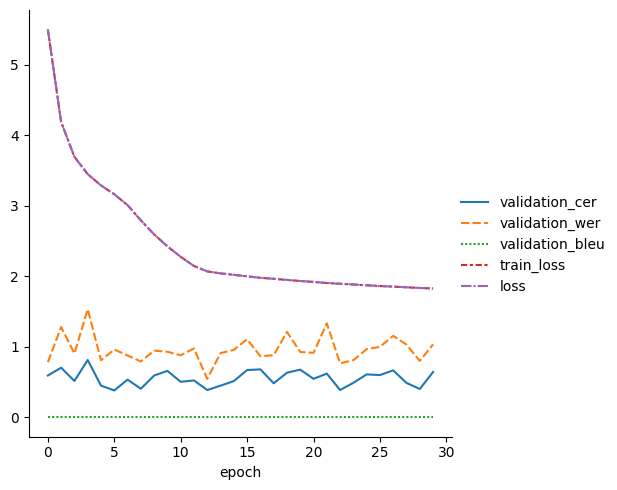

In [10]:
metrics = pd.read_csv("logs/lightning_logs/version_0/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [11]:
# start tensorboard
%load_ext tensorboard
%tensorboard --logdir logs/